In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from einops import rearrange

In [2]:
def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
 
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
    
def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)
    
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
    
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')

        return x

class Cnn14(nn.Module):
    def __init__(self):
        
        super(Cnn14, self).__init__()

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)
        self.conv_block5 = ConvBlock(in_channels=512, out_channels=1024)
        self.conv_block6 = ConvBlock(in_channels=1024, out_channels=2048)

        self.fc1 = nn.Linear(2048, 2048, bias=True)
    
    def forward(self, x):
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.5)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.5)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.5)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.5)
        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.5)
        x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        x = F.dropout(x, p=0.5)
        x = torch.mean(x, dim=3)
        
        (x1, _) = torch.max(x, dim=2)
        x2 = torch.mean(x, dim=2)
        x = x1 + x2
        x = F.dropout(x, p=0.5)
        x = F.relu_(self.fc1(x))
        embedding = F.dropout(x, p=0.5)
        
        return embedding  

class cnn_transfer_cnn14(nn.Module):
    def __init__(self, num_emotions) -> None:
        super().__init__()
    
        self.cnn14 = Cnn14()
        checkpoint = torch.load('pth/Cnn14_16k.pth', map_location='cuda')     # 모델을 동적으로 GPU에 할당
        self.cnn14.load_state_dict(checkpoint['model'], strict=False)         # 더 많은 키를 갖고 있는 경우 strict=False
        
        self.conv2Dblock1 = nn.Sequential(

            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1,  # input volume depth == input channel dim == 1
                out_channels=16,  # expand output feature map volume's depth to 16
                kernel_size=3,  # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
            ),
            # batch normalize the output feature map before activation
            nn.BatchNorm2d(16),
            nn.ReLU(),  # feature map --> activation map
            # typical maxpool kernel size
            nn.MaxPool2d(kernel_size=2, stride=2),
            # randomly zero 30% of 1st layer's output feature map in training
            nn.Dropout(p=0.3),

            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16,
                out_channels=32,  # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # increase maxpool kernel for subsequent filters
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),

            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64,  # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )

        self.conv2Dblock2 = nn.Sequential(

            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1,  # input volume depth == input channel dim == 1
                out_channels=16,  # expand output feature map volume's depth to 16
                kernel_size=3,  # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
            ),
            # batch normalize the output feature map before activation
            nn.BatchNorm2d(16),
            nn.ReLU(),  # feature map --> activation map
            # typical maxpool kernel size
            nn.MaxPool2d(kernel_size=2, stride=2),
            # randomly zero 30% of 1st layer's output feature map in training
            nn.Dropout(p=0.3),

            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16,
                out_channels=32,  # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # increase maxpool kernel for subsequent filters
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),

            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64,  # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        
        self.fc_linear = nn.Linear(3072, num_emotions)
        self.softmax_out = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        cnn14_embedding = self.cnn14(x)
        
        conv2d_embedding1 = self.conv2Dblock1(x)
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1)
        conv2d_embedding2 = self.conv2Dblock2(x)
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1)
        
        complete_embedding = torch.cat([cnn14_embedding, conv2d_embedding1, conv2d_embedding2], dim=1)
        
        output_logits = self.fc_linear(complete_embedding)
        output_softmax = self.softmax_out(output_logits)
        
        return output_logits, output_softmax  

In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Device : {device}')
print(f'Count of using GPUs : {torch.cuda.device_count()}')
print(f'Current cuda device : {torch.cuda.current_device()}\n')

Device : cuda
Count of using GPUs : 1
Current cuda device : 0



In [5]:
from torchinfo import summary

emotions_dict = {
    '0': 'surprised',
    '1': 'neutral',
    '2': 'calm',
    '3': 'happy',
    '4': 'sad',
    '5': 'angry',
    '6': 'fearful',
    '7': 'disgust'
}

model = cnn_transfer_cnn14(num_emotions=len(emotions_dict)).to('cuda')
sub_name = 'cnn_transfer_cnn14'
data_name = 'RAVDESS'
EARLY_CNT = 500

minibatch = 32
num_epochs = 100
print(summary(model, input_size=(minibatch, 1,40,282)))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)

Layer (type:depth-idx)                   Output Shape              Param #
cnn_transfer_cnn14                       [32, 8]                   --
├─Cnn14: 1-1                             [32, 2048]                --
│    └─ConvBlock: 2-1                    [32, 64, 20, 141]         --
│    │    └─Conv2d: 3-1                  [32, 64, 40, 282]         576
│    │    └─BatchNorm2d: 3-2             [32, 64, 40, 282]         128
│    │    └─Conv2d: 3-3                  [32, 64, 40, 282]         36,864
│    │    └─BatchNorm2d: 3-4             [32, 64, 40, 282]         128
│    └─ConvBlock: 2-2                    [32, 128, 10, 70]         --
│    │    └─Conv2d: 3-5                  [32, 128, 20, 141]        73,728
│    │    └─BatchNorm2d: 3-6             [32, 128, 20, 141]        256
│    │    └─Conv2d: 3-7                  [32, 128, 20, 141]        147,456
│    │    └─BatchNorm2d: 3-8             [32, 128, 20, 141]        256
│    └─ConvBlock: 2-3                    [32, 256, 5, 35]          

In [6]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [7]:
def criterion(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

In [8]:
def make_train_step(model, criterion, optimizer):

    # define the training step of the training phase
    def train_step(X, Y):

        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax, dim=1)
        accuracy = torch.sum(Y == predictions)/float(len(Y))

        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y)

        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad()

        return loss.item(), accuracy*100
    return train_step

In [9]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):
        
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
      
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

In [10]:
def train(model, num_epochs, X_train, Y_train, X_valid, Y_valid, pkl_name, fold):
    # instantiate lists to hold scalar performance metrics to plot later
    train_losses = []
    valid_losses = []

    # get training set size to calculate # iterations and minibatch indices
    train_size = X_train.shape[0]

    # instantiate the checkpoint save function
    save_checkpoint = make_save_checkpoint()

    # instantiate the training step function
    train_step = make_train_step(model, criterion, optimizer=optimizer)
    # instantiate the validation loop function
    validate = make_validate_fnc(model, criterion)

    cur_valid_loss = 0x3f3f3f
    early_stop_cnt = 0
    
    for epoch in tqdm(range(num_epochs), desc=f'{fold}'):

        if early_stop_cnt >= EARLY_CNT:
            break
        
        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)

        # shuffle the training set for each epoch:
        X_train = X_train[train_indices, :, :, :]
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate
        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start

            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end, :, :, :]
            # get training minibatch labels
            Y = Y_train[batch_start:batch_end]

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            Y_tensor = torch.tensor(Y, dtype=torch.long, device=device)

            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor, Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}', end='')

        X_valid_tensor = torch.tensor(X_valid, device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid, dtype=torch.long, device=device)

        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor, Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        
        if cur_valid_loss > valid_loss:
            save_checkpoint(optimizer, model, epoch, pkl_name)
            cur_valid_loss = valid_loss
        else:
            early_stop_cnt += 1

        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')

        
    print(f"\n\n[*] done !")
    print(f'[*] Best training loss - {min(train_losses)}')
    print(f'[*] Best validation loss - {min(valid_losses)}')
    
    return train_losses, valid_losses

[*] model training - cnn_transfer_cnn14


fold0.npy:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: iteration 105/106
Epoch 0 --- loss:2.176, Epoch accuracy:14.65%, Validation loss:2.033, Validation accuracy:19.67%
Epoch 1: iteration 105/106
Epoch 1 --- loss:2.008, Epoch accuracy:20.23%, Validation loss:1.993, Validation accuracy:23.67%
Epoch 2: iteration 105/106
Epoch 2 --- loss:1.935, Epoch accuracy:23.36%, Validation loss:2.026, Validation accuracy:22.22%
Epoch 3: iteration 105/106
Epoch 3 --- loss:1.887, Epoch accuracy:26.08%, Validation loss:1.958, Validation accuracy:27.44%
Epoch 4: iteration 105/106
Epoch 4 --- loss:1.835, Epoch accuracy:26.87%, Validation loss:1.968, Validation accuracy:22.67%
Epoch 5: iteration 105/106
Epoch 5 --- loss:1.754, Epoch accuracy:30.82%, Validation loss:1.890, Validation accuracy:27.56%
Epoch 6: iteration 105/106
Epoch 6 --- loss:1.717, Epoch accuracy:33.01%, Validation loss:1.858, Validation accuracy:28.11%
Epoch 7: iteration 105/106
Epoch 7 --- loss:1.646, Epoch accuracy:35.96%, Validation loss:1.757, Validation accuracy:32.89%
Epoch 8:

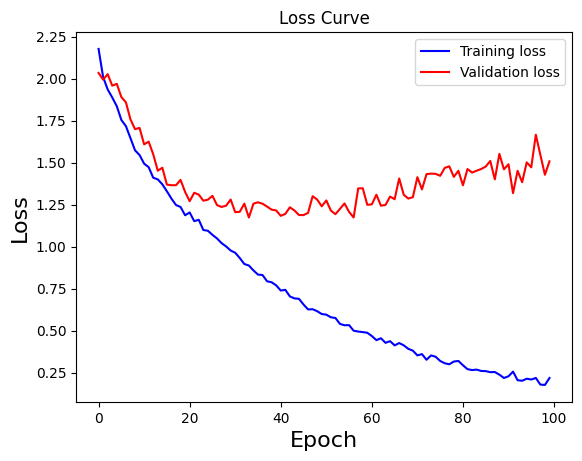

fold1.npy:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: iteration 105/106
Epoch 0 --- loss:0.542, Epoch accuracy:82.98%, Validation loss:0.164, Validation accuracy:94.89%
Epoch 1: iteration 105/106
Epoch 1 --- loss:0.471, Epoch accuracy:83.60%, Validation loss:0.179, Validation accuracy:94.44%
Epoch 2: iteration 105/106
Epoch 2 --- loss:0.436, Epoch accuracy:84.94%, Validation loss:0.185, Validation accuracy:94.56%
Epoch 3: iteration 105/106
Epoch 3 --- loss:0.404, Epoch accuracy:85.50%, Validation loss:0.187, Validation accuracy:93.89%
Epoch 4: iteration 105/106
Epoch 4 --- loss:0.365, Epoch accuracy:87.22%, Validation loss:0.222, Validation accuracy:92.44%
Epoch 5: iteration 105/106
Epoch 5 --- loss:0.383, Epoch accuracy:86.35%, Validation loss:0.193, Validation accuracy:93.22%
Epoch 6: iteration 105/106
Epoch 6 --- loss:0.363, Epoch accuracy:87.34%, Validation loss:0.214, Validation accuracy:93.22%
Epoch 7: iteration 105/106
Epoch 7 --- loss:0.360, Epoch accuracy:86.75%, Validation loss:0.196, Validation accuracy:94.00%
Epoch 8:

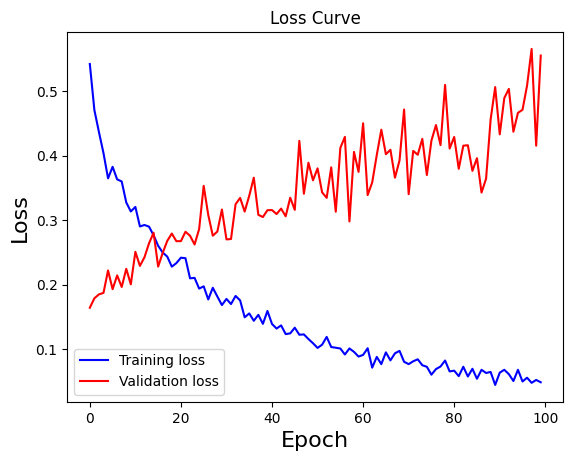

fold2.npy:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: iteration 105/106
Epoch 0 --- loss:0.161, Epoch accuracy:93.71%, Validation loss:0.041, Validation accuracy:98.67%
Epoch 1: iteration 105/106
Epoch 1 --- loss:0.148, Epoch accuracy:93.98%, Validation loss:0.046, Validation accuracy:98.44%
Epoch 2: iteration 105/106
Epoch 2 --- loss:0.151, Epoch accuracy:94.09%, Validation loss:0.044, Validation accuracy:98.67%
Epoch 3: iteration 105/106
Epoch 3 --- loss:0.140, Epoch accuracy:94.97%, Validation loss:0.052, Validation accuracy:98.56%
Epoch 4: iteration 105/106
Epoch 4 --- loss:0.121, Epoch accuracy:94.88%, Validation loss:0.068, Validation accuracy:98.00%
Epoch 5: iteration 105/106
Epoch 5 --- loss:0.114, Epoch accuracy:95.73%, Validation loss:0.058, Validation accuracy:98.56%
Epoch 6: iteration 105/106
Epoch 6 --- loss:0.107, Epoch accuracy:95.12%, Validation loss:0.074, Validation accuracy:97.22%
Epoch 7: iteration 105/106
Epoch 7 --- loss:0.097, Epoch accuracy:95.91%, Validation loss:0.057, Validation accuracy:98.00%
Epoch 8:

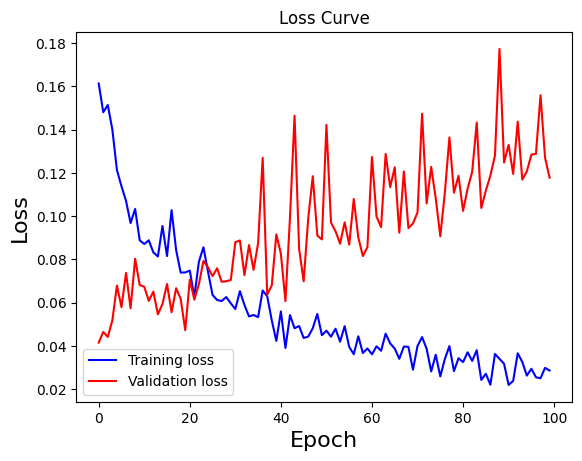

fold3.npy:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: iteration 105/106
Epoch 0 --- loss:0.082, Epoch accuracy:96.52%, Validation loss:0.019, Validation accuracy:99.44%
Epoch 1: iteration 105/106
Epoch 1 --- loss:0.063, Epoch accuracy:97.08%, Validation loss:0.016, Validation accuracy:99.56%
Epoch 2: iteration 105/106
Epoch 2 --- loss:0.055, Epoch accuracy:97.13%, Validation loss:0.017, Validation accuracy:99.22%
Epoch 3: iteration 105/106
Epoch 3 --- loss:0.062, Epoch accuracy:97.02%, Validation loss:0.012, Validation accuracy:99.67%
Epoch 4: iteration 105/106
Epoch 4 --- loss:0.064, Epoch accuracy:96.90%, Validation loss:0.016, Validation accuracy:99.56%
Epoch 5: iteration 105/106
Epoch 5 --- loss:0.063, Epoch accuracy:96.99%, Validation loss:0.028, Validation accuracy:99.44%
Epoch 6: iteration 105/106
Epoch 6 --- loss:0.064, Epoch accuracy:97.16%, Validation loss:0.015, Validation accuracy:99.67%
Epoch 7: iteration 105/106
Epoch 7 --- loss:0.053, Epoch accuracy:97.40%, Validation loss:0.015, Validation accuracy:99.67%
Epoch 8:

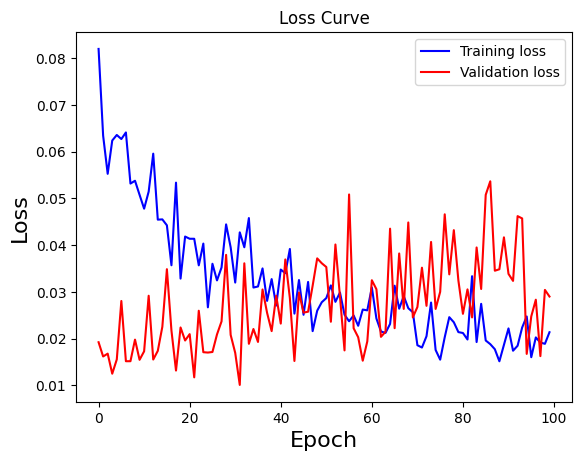

fold4.npy:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: iteration 111/112
Epoch 0 --- loss:0.035, Epoch accuracy:98.53%, Validation loss:0.009, Validation accuracy:99.58%
Epoch 1: iteration 111/112
Epoch 1 --- loss:0.030, Epoch accuracy:98.42%, Validation loss:0.004, Validation accuracy:99.86%
Epoch 2: iteration 111/112
Epoch 2 --- loss:0.029, Epoch accuracy:98.56%, Validation loss:0.007, Validation accuracy:99.86%
Epoch 3: iteration 111/112
Epoch 3 --- loss:0.028, Epoch accuracy:98.56%, Validation loss:0.009, Validation accuracy:99.58%
Epoch 4: iteration 111/112
Epoch 4 --- loss:0.019, Epoch accuracy:99.08%, Validation loss:0.010, Validation accuracy:99.58%
Epoch 5: iteration 111/112
Epoch 5 --- loss:0.023, Epoch accuracy:98.78%, Validation loss:0.015, Validation accuracy:99.58%
Epoch 6: iteration 111/112
Epoch 6 --- loss:0.026, Epoch accuracy:98.61%, Validation loss:0.009, Validation accuracy:99.58%
Epoch 7: iteration 111/112
Epoch 7 --- loss:0.032, Epoch accuracy:98.47%, Validation loss:0.008, Validation accuracy:99.72%
Epoch 8:

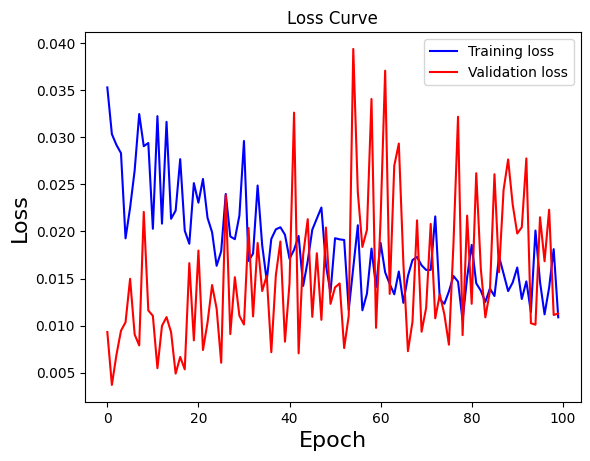

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

npy_path = './npy'
all_npy = os.listdir(npy_path)

test_accs = []
train_losses, valid_losses = [], []

print(f'[*] model training - {sub_name}')
for fold in all_npy:
    npy = os.path.join(npy_path, fold)
    
    with open(npy, 'rb') as f:
        X_train = np.load(f)
        X_test = np.load(f)
        y_train = np.load(f)
        y_test = np.load(f)
    
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    train_losses, valid_losses = train(model, num_epochs, X_train, y_train, X_test, y_test, pkl_name, fold)
    
    plt.title('Loss Curve')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(train_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])
    plt.show()

./npy\fold0.npy
[*] fold0.npy Test accuracy is 58.00%


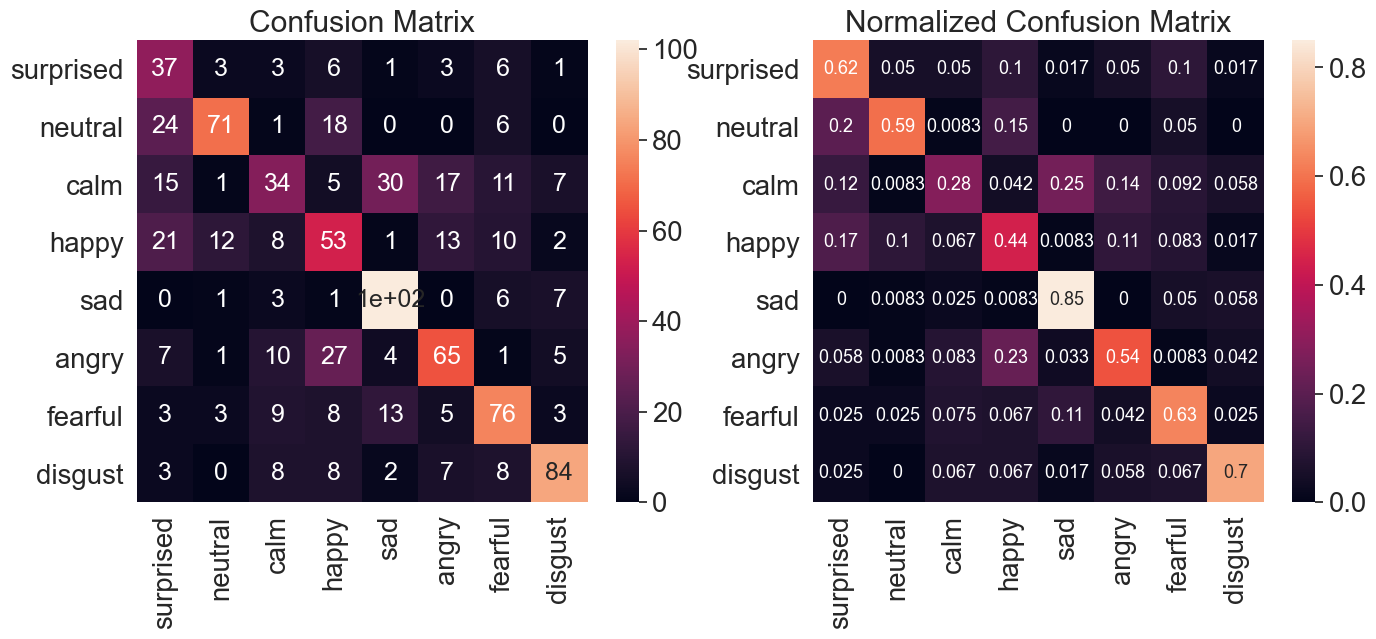

./npy\fold1.npy
[*] fold1.npy Test accuracy is 93.78%


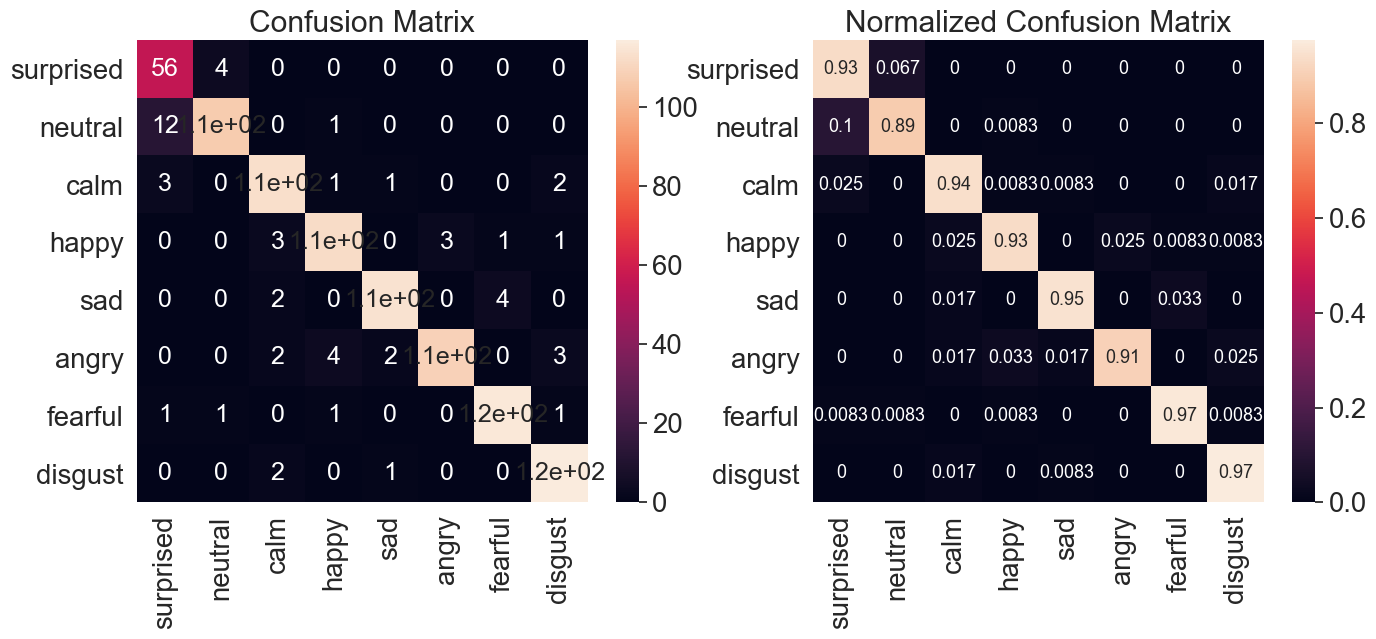

./npy\fold2.npy
[*] fold2.npy Test accuracy is 98.67%


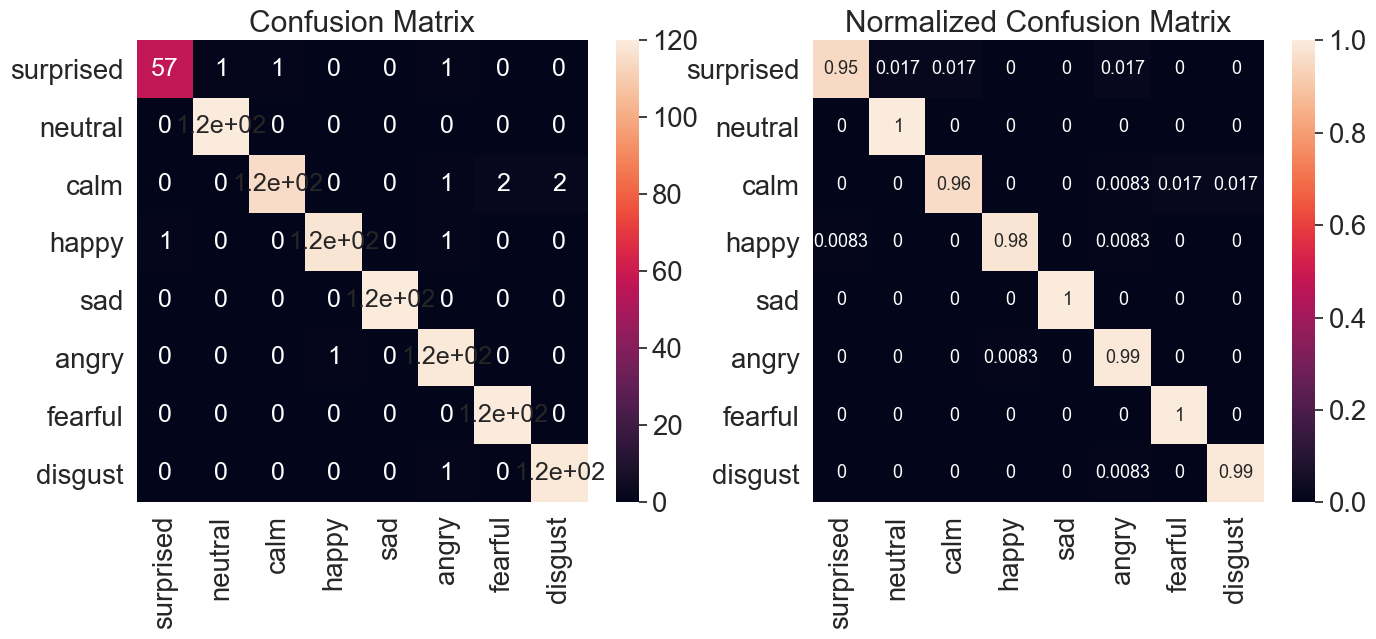

./npy\fold3.npy
[*] fold3.npy Test accuracy is 99.33%


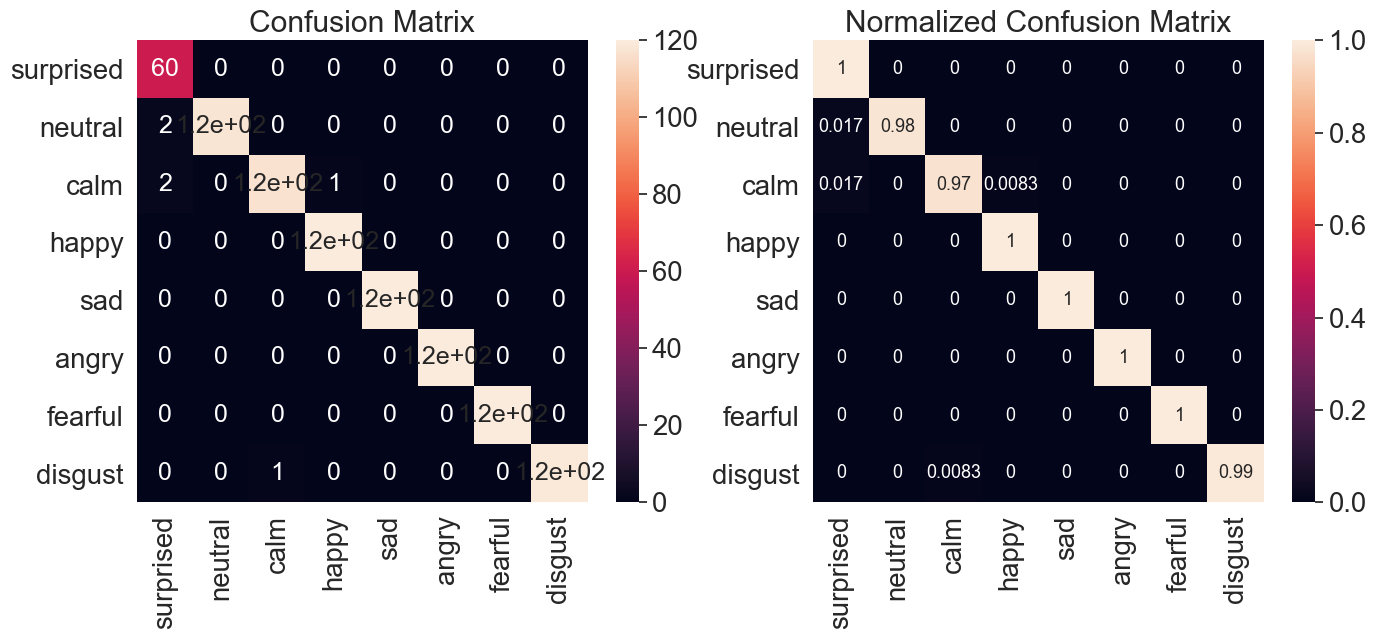

./npy\fold4.npy
[*] fold4.npy Test accuracy is 99.86%


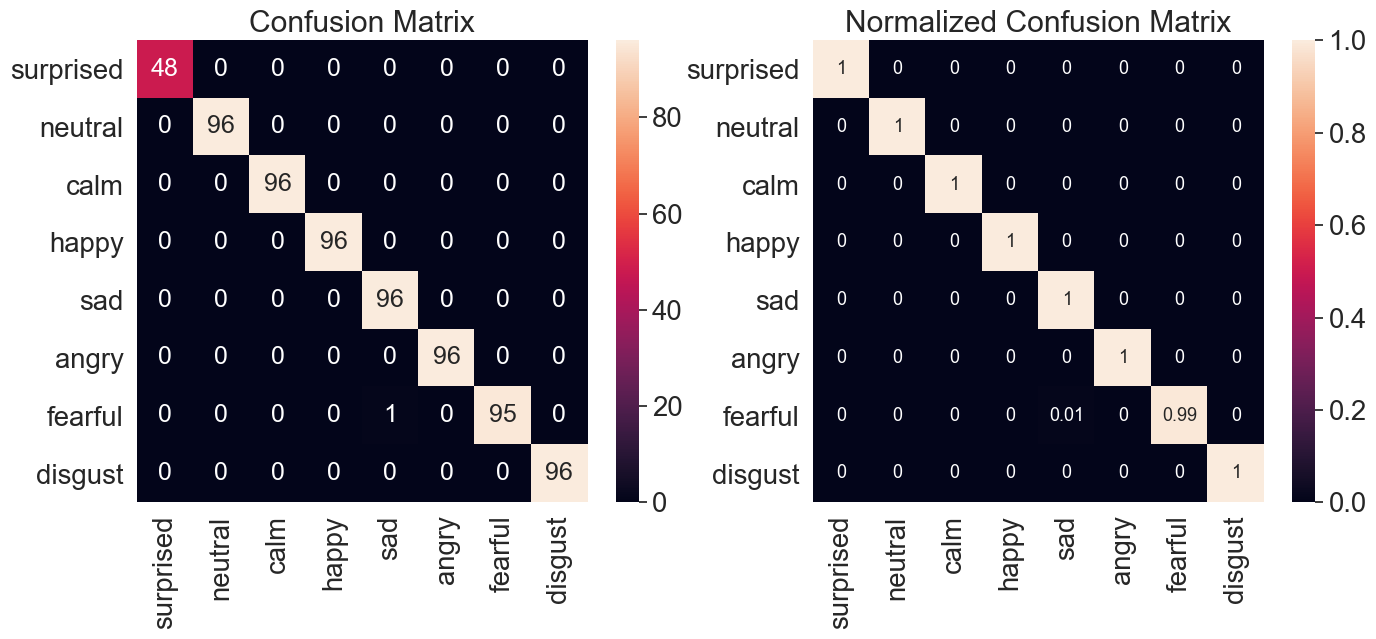

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

npy_path = './npy'
all_npy = os.listdir(npy_path)

model = cnn_transfer_cnn14(num_emotions=len(emotions_dict))

test_accs = []


for fold in all_npy:
    npy = os.path.join(npy_path, fold)
    
    with open(npy, 'rb') as f:
        X_train = np.load(f)
        X_test = np.load(f)
        y_train = np.load(f)
        y_test = np.load(f)
    
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    
    load_checkpoint(optimizer, model, pkl_name)
    
    validate = make_validate_fnc(model, criterion)
    
    print(npy)
    
    X_test_tensor = torch.tensor(X_test).float()
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    test_loss, test_acc, predicted_emotions = validate(X_test_tensor, y_test_tensor)
    print(f'[*] {fold} Test accuracy is {test_acc:.2f}%')
    test_accs.append(test_acc)
    
    predicted_emotions = predicted_emotions.cpu().numpy()
    # use labels from test set
    emotions_groundtruth = y_test

    # build confusion matrix and normalized confusion matrix
    conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
    conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

    # set labels for matrix axes from emotions
    emotion_names = [emotion for emotion in emotions_dict.values()]

    # make a confusion matrix with labels using a DataFrame
    confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
    confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

    # plot confusion matrices
    plt.figure(figsize=(16,6))
    sn.set(font_scale=1.8) # emotion label and title size
    plt.subplot(1,2,1)
    plt.title('Confusion Matrix')
    sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
    plt.subplot(1,2,2)
    plt.title('Normalized Confusion Matrix')
    sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

    plt.show()

In [14]:
def Average(lst):
    return sum(lst) / len(lst)

print('[*] K-Fold training done !')
print(f'[*] Best fold acc : {max(test_accs):.2f}%')
print(f'[*] Worst fold acc : {min(test_accs):.2f}%')
print(f'[*] Average fold acc : {Average(test_accs):.2f}%')

[*] K-Fold training done !
[*] Best fold acc : 99.86%
[*] Worst fold acc : 58.00%
[*] Average fold acc : 89.93%
